<a href="https://colab.research.google.com/github/AjaySreekumar47/M-Time-series-forecasting-competition/blob/main/notebook/MForecasting1001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M1 Competition Forecasting Project

Time Series Forecasting with the M1 Competition Dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## Step 1: Data Loading and Preprocessing

In [33]:
# Function to load the data from Excel file
def load_m1_data(file_path):
    """
    Load M1 competition data from Excel file
    """
    try:
        # Load main data sheet
        data_df = pd.read_excel(file_path, sheet_name=0)  # First sheet

        # Load seasonality indicators
        seas_df = pd.read_excel(file_path, sheet_name=1)  # Second sheet

        # Print column names for debugging
        print("Data columns:", data_df.columns.tolist())
        print("First few rows of data:")
        print(data_df.head())

        return data_df, seas_df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Function to format data for time series analysis
def prepare_time_series(data_df, series_id):
    """
    Prepare a single time series for analysis
    """
    # Handle trailing spaces in series IDs
    # First try direct match
    series_row = data_df[data_df['Series'] == series_id]

    # If not found, try with trimming spaces
    if len(series_row) == 0:
        # Look for series with spaces trimmed
        series_row = data_df[data_df['Series'].str.strip() == series_id.strip()]

        if len(series_row) == 0:
            # Print all series IDs for debugging
            print(f"Could not find series '{series_id}' in dataset")
            print("Available series (first 10):", data_df['Series'].head(10).tolist())
            raise ValueError(f"Series {series_id} not found in the dataset")

    series_row = series_row.iloc[0]

    # Get metadata
    start_year = series_row['Starting date']
    n_obs = int(series_row['N Obs'])
    category = series_row['Category']

    # Extract the time series values
    # Create a list of numeric column names
    numeric_cols = [col for col in data_df.columns if isinstance(col, int) or
                   (isinstance(col, str) and col.isdigit())]

    # If no numeric columns found, use position-based access
    if not numeric_cols:
        # Find columns that might contain the time series data
        # Start after the last metadata column (typically 'Category')
        potential_data_cols = list(range(7, 7+n_obs))
        values = []
        for i in potential_data_cols:
            if i < len(series_row):
                values.append(series_row.iloc[i])
            else:
                break
    else:
        # Use only the first n_obs numeric columns
        numeric_cols = sorted(numeric_cols)[:n_obs]
        values = series_row[numeric_cols].values

    # Ensure values are numeric and handle any potential strings or NaN values
    clean_values = []
    for val in values:
        try:
            clean_val = float(val)
            if not np.isnan(clean_val):
                clean_values.append(clean_val)
        except (ValueError, TypeError):
            print(f"Skipping non-numeric value: {val}")

    # Print info about the extracted values
    print(f"Extracted {len(clean_values)} numeric values out of {n_obs} expected observations")

    # Create a time series with proper dates
    years = pd.date_range(start=f"{start_year}-01-01", periods=len(clean_values), freq='YS')
    ts_df = pd.DataFrame({'date': years, 'value': clean_values})
    ts_df.set_index('date', inplace=True)

    # Convert to numeric to ensure no object dtype
    ts_df['value'] = pd.to_numeric(ts_df['value'], errors='coerce')

    # Drop any remaining NaN values
    ts_df = ts_df.dropna()

    print(f"Final time series shape: {ts_df.shape}, dtype: {ts_df['value'].dtype}")

    return ts_df, {'category': category, 'start_year': start_year, 'n_obs': len(clean_values)}

## Step 2: Exploratory Data Analysis

In [34]:
def explore_time_series(ts_df, series_id, metadata):
    """
    Perform exploratory analysis on a time series
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # Plot the time series
    axes[0].plot(ts_df.index, ts_df['value'], marker='o')
    axes[0].set_title(f"Time Series: {series_id} ({metadata['category']})")
    axes[0].set_ylabel('Value')

    # Calculate appropriate lag for ACF/PACF based on dataset size
    # For PACF, max lag should be less than 50% of sample size
    # For ACF, we can use more lags
    max_acf_lags = min(20, len(ts_df)-1)
    max_pacf_lags = min(10, int(len(ts_df)*0.4))  # Ensure it's less than 50%

    print(f"Using {max_acf_lags} lags for ACF and {max_pacf_lags} lags for PACF")

    # Plot the ACF
    try:
        plot_acf(ts_df['value'], ax=axes[1], lags=max_acf_lags)
        axes[1].set_title('Autocorrelation Function (ACF)')
    except Exception as e:
        print(f"Error plotting ACF: {e}")
        axes[1].text(0.5, 0.5, "Error plotting ACF",
                     horizontalalignment='center', verticalalignment='center')

    # Plot the PACF
    try:
        plot_pacf(ts_df['value'], ax=axes[2], lags=max_pacf_lags)
        axes[2].set_title('Partial Autocorrelation Function (PACF)')
    except Exception as e:
        print(f"Error plotting PACF: {e}")
        axes[2].text(0.5, 0.5, "Error plotting PACF",
                     horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    # Calculate basic statistics
    stats = ts_df['value'].describe()
    print(f"Statistics for {series_id}:")
    print(stats)

    # Check for stationarity
    try:
        from statsmodels.tsa.stattools import adfuller
        result = adfuller(ts_df['value'])
        print('\nAugmented Dickey-Fuller Test:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')

        # Stationarity interpretation
        if result[1] <= 0.05:
            print("The time series is stationary (reject null hypothesis)")
        else:
            print("The time series is non-stationary (fail to reject null hypothesis)")
    except Exception as e:
        print(f"Error in stationarity test: {e}")

    return stats

## Step 3: Train-Test Split

In [35]:
def train_test_split(ts_df, test_size=0.2):
    """
    Split time series into training and test sets
    """
    n = len(ts_df)
    train_size = int(n * (1 - test_size))

    train = ts_df.iloc[:train_size]
    test = ts_df.iloc[train_size:]

    return train, test

## Step 4: Implement Forecasting Models

In [36]:
# Naive Forecast (last value)
def naive_forecast(train, test):
    """
    Generate naive forecasts (using last observed value)
    """
    last_value = train['value'].iloc[-1]
    naive_predictions = pd.DataFrame(
        index=test.index,
        data={'forecast': [last_value] * len(test)}
    )
    return naive_predictions

# ARIMA Model
def arima_forecast(train, test, order=(1,1,1)):
    """
    Generate forecasts using ARIMA model
    """
    # Ensure data is numeric
    train_values = pd.to_numeric(train['value'], errors='coerce').dropna().values

    # Check if we have enough data
    if len(train_values) < sum(order) + 1:
        raise ValueError(f"Not enough observations for ARIMA{order}. Need at least {sum(order)+1}, got {len(train_values)}")

    model = ARIMA(train_values, order=order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))
    arima_predictions = pd.DataFrame(
        index=test.index,
        data={'forecast': forecast}
    )

    return arima_predictions, model_fit

# Exponential Smoothing
def exp_smoothing_forecast(train, test, seasonal=False):
    """
    Generate forecasts using exponential smoothing
    """
    # Ensure data is numeric
    train_values = pd.to_numeric(train['value'], errors='coerce').dropna()

    if len(train_values) < 3:
        raise ValueError(f"Not enough observations for Exponential Smoothing. Need at least 3, got {len(train_values)}")

    if seasonal:
        model = ExponentialSmoothing(
            train_values,
            trend='add',
            seasonal='add',
            seasonal_periods=1  # Set to appropriate value for seasonal data
        )
    else:
        model = ExponentialSmoothing(
            train_values,
            trend='add',
            seasonal=None
        )

    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))
    es_predictions = pd.DataFrame(
        index=test.index,
        data={'forecast': forecast}
    )

    return es_predictions, model_fit

## Step 5: Evaluate Models

In [37]:
# Evaluate forecasts
def evaluate_forecasts(test, predictions_dict):
    """
    Evaluate forecasting models using various metrics
    """
    results = {}

    for model_name, predictions in predictions_dict.items():
        try:
            # Ensure both test and predictions are numeric
            test_values = pd.to_numeric(test['value'], errors='coerce').dropna()
            pred_values = pd.to_numeric(predictions['forecast'], errors='coerce').dropna()

            # Align the indices
            aligned_data = pd.concat([test_values, pred_values], axis=1)
            aligned_data.columns = ['actual', 'predicted']
            aligned_data = aligned_data.dropna()

            # Skip if we don't have enough aligned data points
            if len(aligned_data) < 1:
                print(f"Warning: Not enough aligned data points for {model_name}")
                results[model_name] = {
                    'MSE': np.nan,
                    'RMSE': np.nan,
                    'MAE': np.nan,
                    'MAPE': np.nan
                }
                continue

            # Calculate metrics
            mse = mean_squared_error(aligned_data['actual'], aligned_data['predicted'])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(aligned_data['actual'], aligned_data['predicted'])

            # Handle division by zero in MAPE calculation
            if (aligned_data['actual'] == 0).any():
                print(f"Warning: Zero values in test data, MAPE may be undefined for {model_name}")
                # Use a small epsilon to avoid division by zero
                epsilon = 1e-10
                mape = np.mean(np.abs((aligned_data['actual'] - aligned_data['predicted']) /
                                      (np.abs(aligned_data['actual']) + epsilon))) * 100
            else:
                mape = mean_absolute_percentage_error(aligned_data['actual'], aligned_data['predicted']) * 100

            results[model_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            results[model_name] = {
                'MSE': np.nan,
                'RMSE': np.nan,
                'MAE': np.nan,
                'MAPE': np.nan,
                'Error': str(e)
            }

    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results).T

    return results_df

# Plot forecasts against actual values
def plot_forecasts(train, test, predictions_dict):
    """
    Plot actual values vs forecasts for each model
    """
    plt.figure(figsize=(14, 8))

    # Ensure data is numeric
    train_values = pd.to_numeric(train['value'], errors='coerce')
    test_values = pd.to_numeric(test['value'], errors='coerce')

    # Plot training data
    plt.plot(train.index, train_values, label='Training Data', color='black', marker='o')

    # Plot test data
    plt.plot(test.index, test_values, label='Actual Values', color='blue', linestyle='--', marker='o')

    # Plot predictions for each model
    colors = ['red', 'green', 'purple', 'orange', 'brown']
    for i, (model_name, predictions) in enumerate(predictions_dict.items()):
        color = colors[i % len(colors)]
        pred_values = pd.to_numeric(predictions['forecast'], errors='coerce')
        plt.plot(predictions.index, pred_values, label=f'{model_name} Forecast', color=color, marker='s')

    plt.title('Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Add a text annotation for the first and last data points to aid in debugging
    for i, (idx, val) in enumerate(test_values.items()):
        if i == 0 or i == len(test_values) - 1:
            plt.annotate(f'{val:.1f}', (idx, val), textcoords="offset points",
                         xytext=(0,10), ha='center')

    plt.show()

## Step 6: Main Analysis Function

In [38]:
def analyze_series(file_path, series_id, test_size=0.2):
    """
    Perform complete analysis on a specific series
    """
    print(f"Analyzing series: {series_id}")
    print("=" * 50)

    try:
        # Load data
        data_df, seas_df = load_m1_data(file_path)

        # Check if series exists (using both exact and stripped comparison)
        if series_id not in data_df['Series'].values and series_id.strip() not in data_df['Series'].str.strip().values:
            available_series = data_df['Series'].tolist()
            print(f"Series {series_id} not found in dataset.")
            print(f"Available series (first 10): {[s.strip() for s in available_series[:10]]}")
            return None, None, None, None, None

        # Prepare time series
        ts_df, metadata = prepare_time_series(data_df, series_id)
        print(f"Series metadata: {metadata}")

        # Check if we have enough data
        if len(ts_df) < 5:  # Need at least 5 points for meaningful analysis
            print(f"Not enough data points in series {series_id} for analysis")
            return ts_df, None, None, None, None

        # Explore time series
        stats = explore_time_series(ts_df, series_id, metadata)

        # Split into train and test sets
        train, test = train_test_split(ts_df, test_size=test_size)
        print(f"Training set size: {len(train)}")
        print(f"Test set size: {len(test)}")

        if len(test) < 1:
            print("Test set is empty after split. Adjusting test_size...")
            train, test = train_test_split(ts_df, test_size=1/len(ts_df))
            print(f"New training set size: {len(train)}")
            print(f"New test set size: {len(test)}")

        # Generate forecasts
        naive_predictions = naive_forecast(train, test)

        try:
            es_predictions, es_model = exp_smoothing_forecast(train, test)
        except Exception as e:
            print(f"Error in exponential smoothing: {e}")
            # Create dummy predictions with NaN
            es_predictions = pd.DataFrame(
                index=test.index,
                data={'forecast': [np.nan] * len(test)}
            )

        # Determine ARIMA order
        try:
            # Check if differencing is needed based on ADF test
            from statsmodels.tsa.stattools import adfuller
            result = adfuller(train['value'])
            d = 1 if result[1] > 0.05 else 0
            arima_order = (1, d, 1)  # Simple default

            arima_predictions, arima_model = arima_forecast(train, test, order=arima_order)
        except Exception as e:
            print(f"Error in ARIMA modeling: {e}")
            # Create dummy predictions with NaN
            arima_predictions = pd.DataFrame(
                index=test.index,
                data={'forecast': [np.nan] * len(test)}
            )

        # Combine all predictions
        predictions_dict = {
            'Naive': naive_predictions
        }

        # Only add models that worked
        if not es_predictions['forecast'].isna().all():
            predictions_dict['Exponential Smoothing'] = es_predictions

        if not arima_predictions['forecast'].isna().all():
            predictions_dict['ARIMA'] = arima_predictions

        # Evaluate forecasts
        results = evaluate_forecasts(test, predictions_dict)
        print("\nForecast Evaluation:")
        print(results)

        # Plot forecasts
        plot_forecasts(train, test, predictions_dict)

        return ts_df, train, test, predictions_dict, results

    except Exception as e:
        print(f"Error in analyze_series: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

## Step 7: Run the Analysis

In [39]:
# Helper function to add to the analyze_multiple_series function
def find_matching_series(data_df, target_series_id):
    """
    Find a series that matches the target ID, handling trailing spaces
    """
    # Try exact match first
    if target_series_id in data_df['Series'].values:
        return target_series_id

    # Try stripped match
    stripped_id = target_series_id.strip()
    for series in data_df['Series']:
        if series.strip() == stripped_id:
            return series

    return None  # No match found

# Additional function to analyze multiple series
def analyze_multiple_series(file_path, series_ids, test_size=0.2):
    """
    Analyze multiple series and compare results
    """
    all_results = {}

    # First load the data to check series IDs
    data_df, _ = load_m1_data(file_path)

    for target_series_id in series_ids:
        # Find the actual series ID with correct spacing
        actual_series_id = find_matching_series(data_df, target_series_id)

        if actual_series_id:
            print(f"Found matching series '{actual_series_id}' for requested '{target_series_id}'")
            _, _, _, _, results = analyze_series(file_path, actual_series_id, test_size)
            if results is not None:
                all_results[target_series_id] = results
        else:
            print(f"Could not find series matching '{target_series_id}'")

    if not all_results:
        print("No valid results to compare.")
        return None, None

    # Compare MAPE across all series
    mape_comparison = {}
    for series_id, results in all_results.items():
        mape_comparison[series_id] = results['MAPE']

    mape_df = pd.DataFrame(mape_comparison)

    # Plot MAPE comparison
    plt.figure(figsize=(14, 8))
    mape_df.plot(kind='bar')
    plt.title('MAPE Comparison Across Series')
    plt.ylabel('MAPE (%)')
    plt.xlabel('Forecasting Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return all_results, mape_df

# Example usage for multiple series
# series_ids = ['YAF2', 'YAF3']
# all_results, mape_comparison = analyze_multiple_series(file_path, series_ids)

## Step 8: Interactive Running for Google Colab

Analyzing series: YAF2
Data columns: ['Series', 'N Obs', 'Seasonality', 'NF', 'Type', 'Starting date', 'Category', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 'Unnamed: 157', 'Unnamed: 158', 'Unnamed: 159', 'Unnamed: 160', 'Unnamed: 161', 'Unnamed: 162', 'Unnamed: 163', 'Unnamed: 164', 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]
First few rows of data:
   Ser

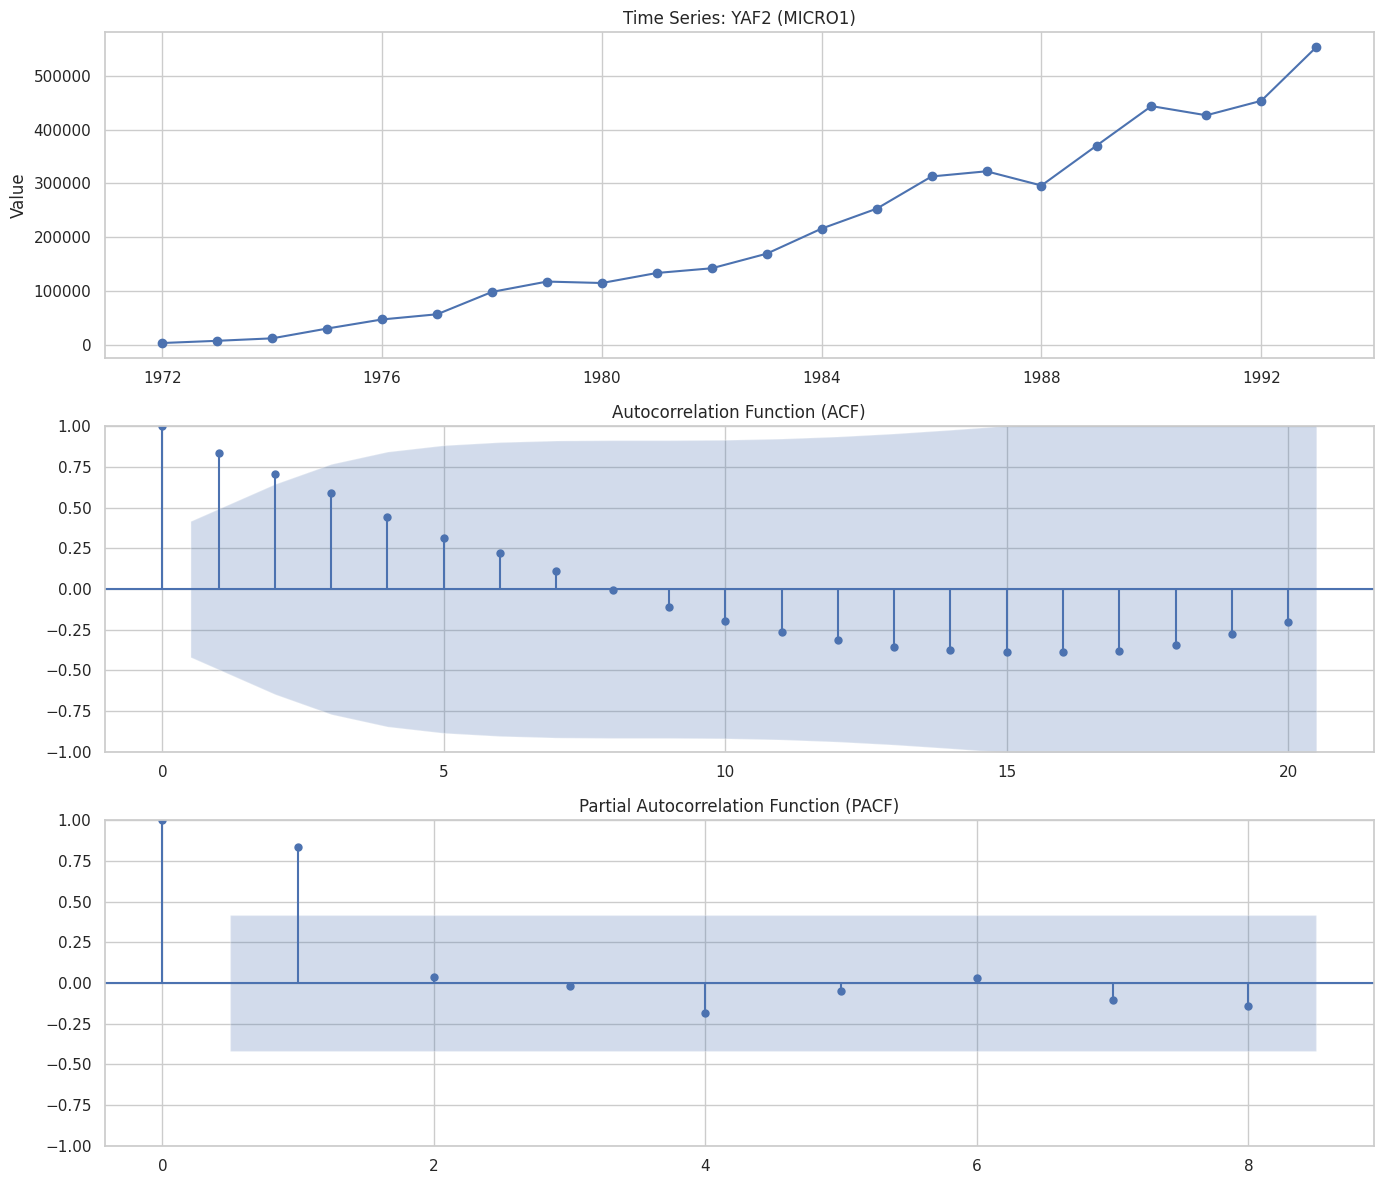

Statistics for YAF2:
count        22.000000
mean     208417.500000
std      166743.687216
min        3600.000000
25%       67395.250000
50%      156048.000000
75%      320284.750000
max      553400.000000
Name: value, dtype: float64

Augmented Dickey-Fuller Test:
ADF Statistic: -0.5853802328966663
p-value: 0.874251393936639
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443
The time series is non-stationary (fail to reject null hypothesis)
Training set size: 17
Test set size: 5

Forecast Evaluation:
                                MSE           RMSE            MAE       MAPE
Naive                  2.703976e+10  164437.700841  153342.400000  33.000282
Exponential Smoothing  1.257517e+10  112139.078753  104672.768230  22.585853
ARIMA                  4.039568e+10  200986.758789  189304.333727  40.893226


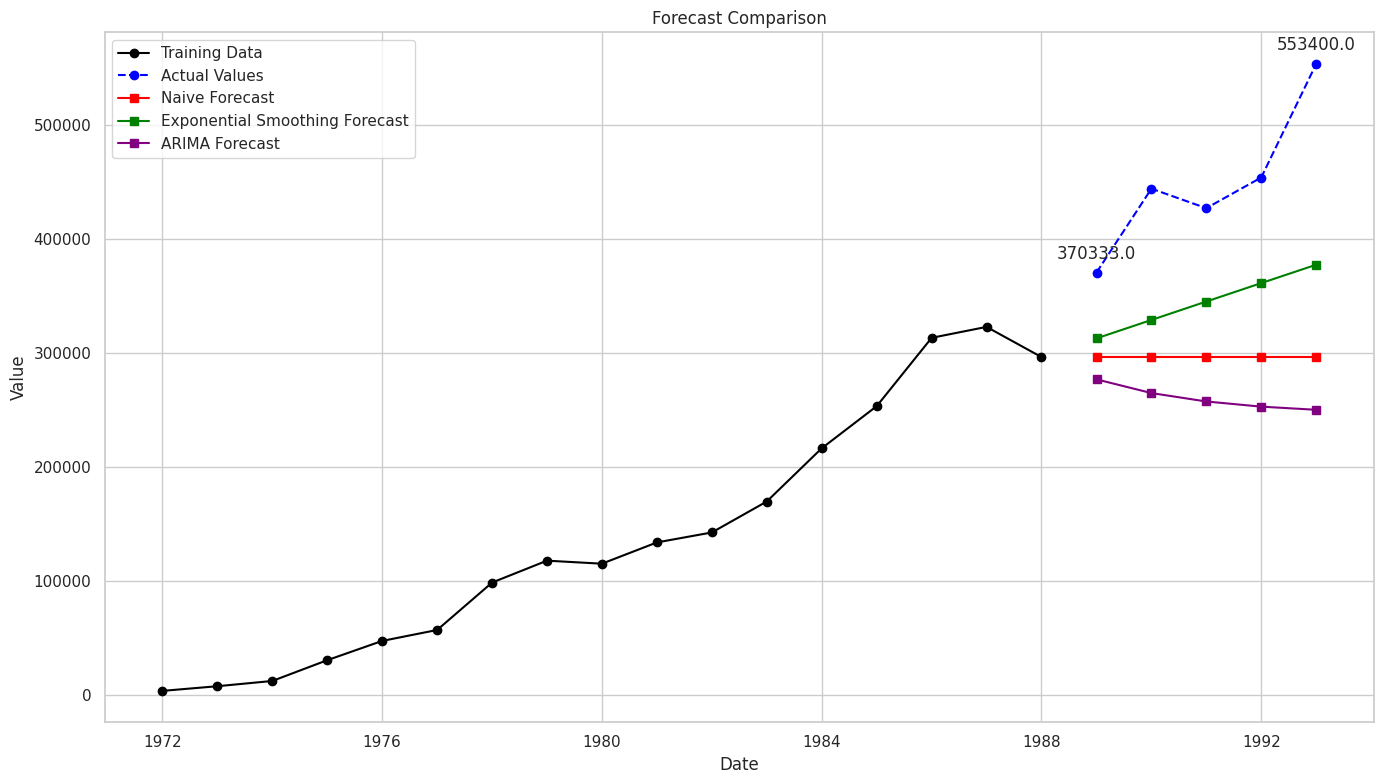

In [40]:
# Set your file path (update with your specific path)
file_path = '/content/MC1001.xls'

# Run for a single series
series_to_analyze = 'YAF2'  # Update with your chosen series
ts_df, train, test, predictions, results = analyze_series(file_path, series_to_analyze)

Data columns: ['Series', 'N Obs', 'Seasonality', 'NF', 'Type', 'Starting date', 'Category', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 'Unnamed: 157', 'Unnamed: 158', 'Unnamed: 159', 'Unnamed: 160', 'Unnamed: 161', 'Unnamed: 162', 'Unnamed: 163', 'Unnamed: 164', 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]
First few rows of data:
   Series  N Obs  Seasonality

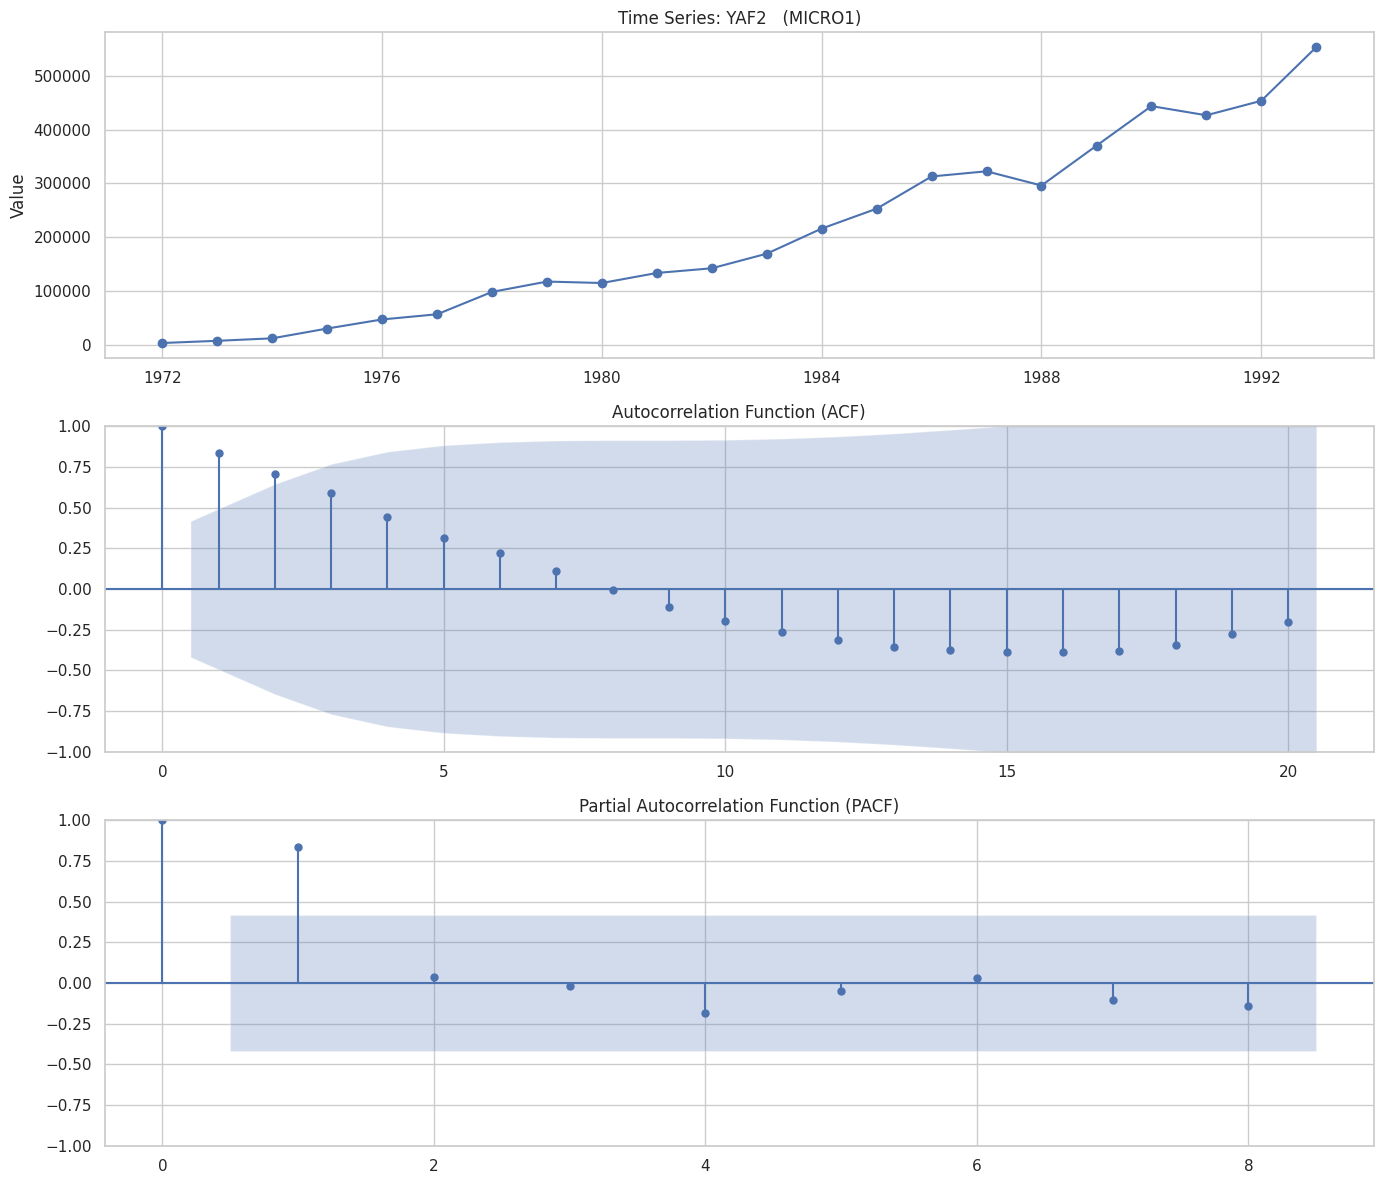

Statistics for YAF2  :
count        22.000000
mean     208417.500000
std      166743.687216
min        3600.000000
25%       67395.250000
50%      156048.000000
75%      320284.750000
max      553400.000000
Name: value, dtype: float64

Augmented Dickey-Fuller Test:
ADF Statistic: -0.5853802328966663
p-value: 0.874251393936639
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443
The time series is non-stationary (fail to reject null hypothesis)
Training set size: 17
Test set size: 5

Forecast Evaluation:
                                MSE           RMSE            MAE       MAPE
Naive                  2.703976e+10  164437.700841  153342.400000  33.000282
Exponential Smoothing  1.257517e+10  112139.078753  104672.768230  22.585853
ARIMA                  4.039568e+10  200986.758789  189304.333727  40.893226


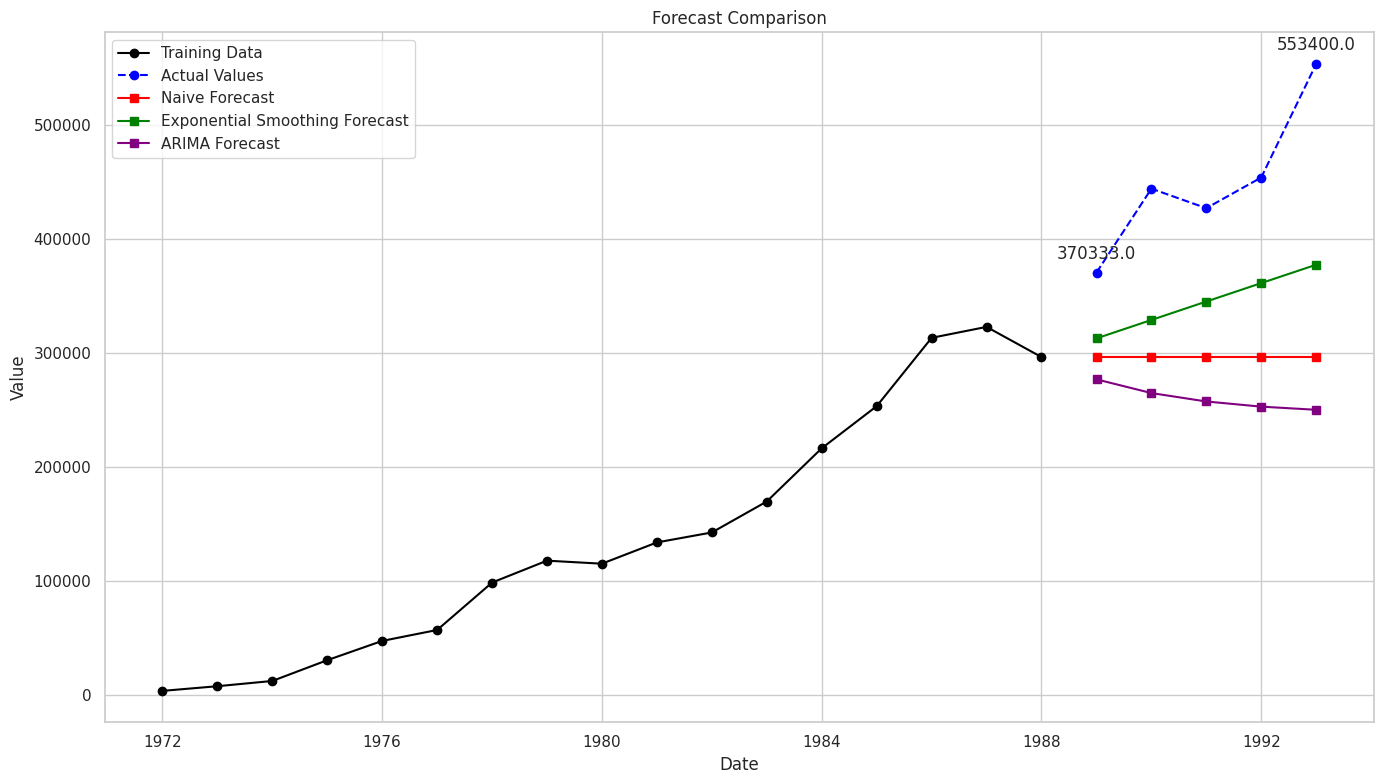

Found matching series 'YAF3  ' for requested 'YAF3'
Analyzing series: YAF3  
Data columns: ['Series', 'N Obs', 'Seasonality', 'NF', 'Type', 'Starting date', 'Category', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 'Unnamed: 157', 'Unnamed: 158', 'Unnamed: 159', 'Unnamed: 160', 'Unnamed: 161', 'Unnamed: 162', 'Unnamed: 163', 'Unnamed: 164', 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 1

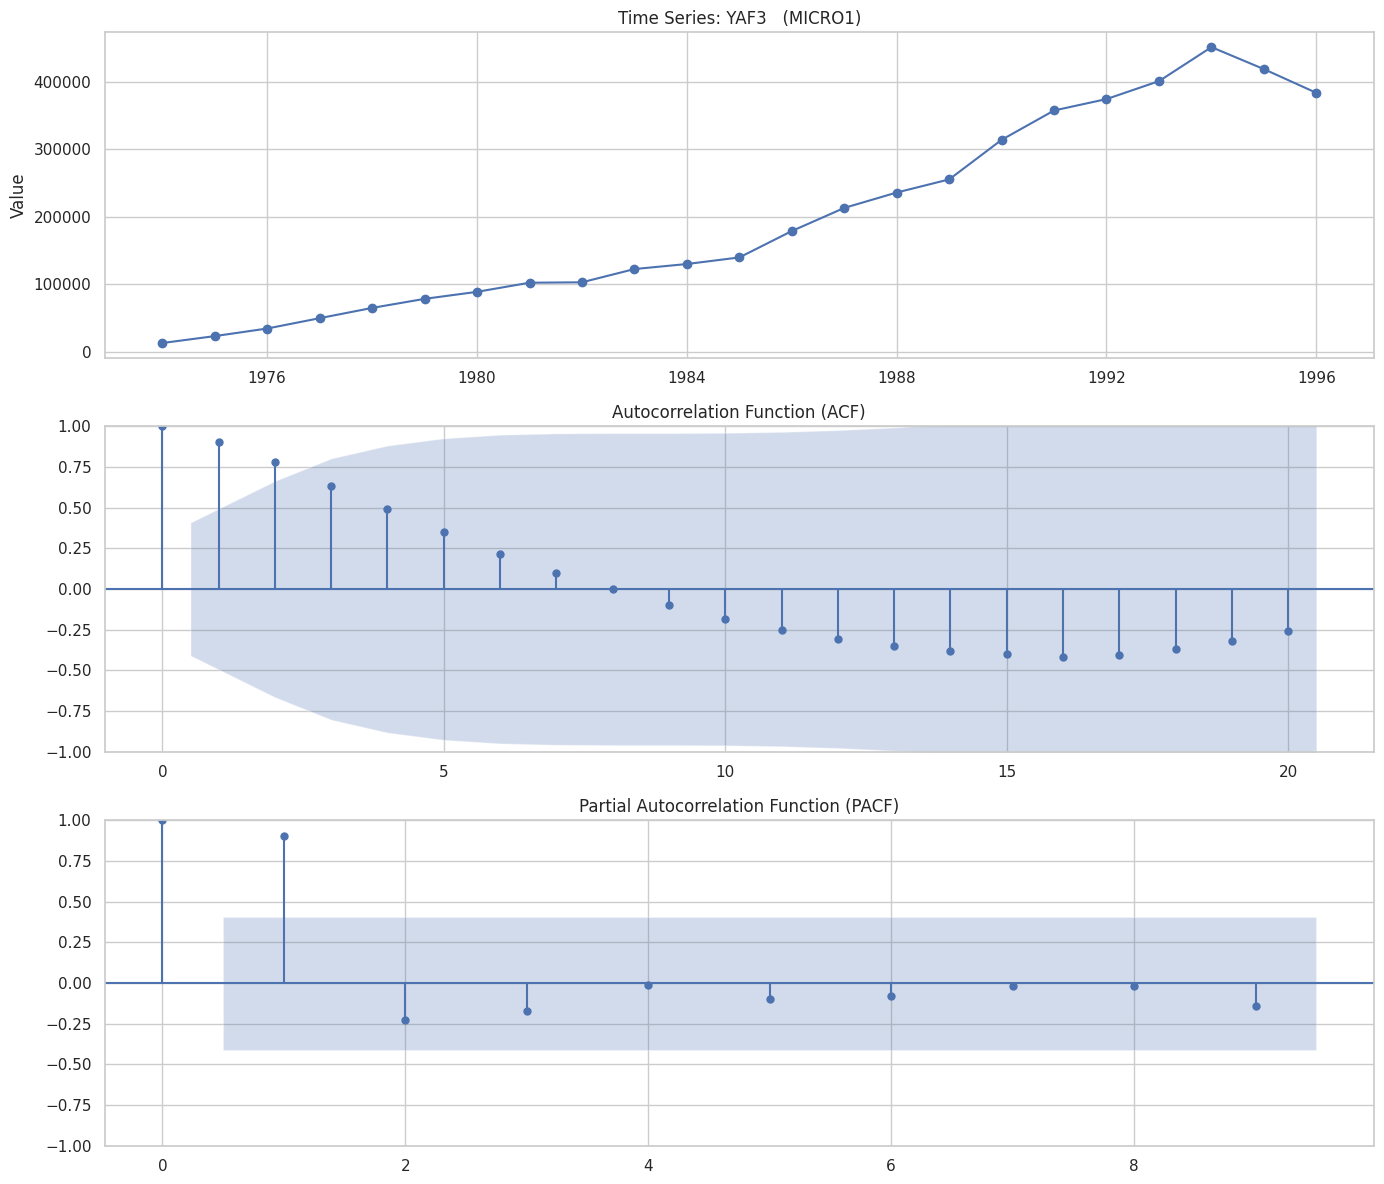

Statistics for YAF3  :
count        23.000000
mean     197165.826087
std      143814.349936
min       12654.000000
25%       83412.500000
50%      139706.000000
75%      336045.500000
max      451875.000000
Name: value, dtype: float64

Augmented Dickey-Fuller Test:
ADF Statistic: -2.046330861332136
p-value: 0.2666351151620804
Critical Values:
	1%: -3.859073285322359
	5%: -3.0420456927297668
	10%: -2.6609064197530863
The time series is non-stationary (fail to reject null hypothesis)
Training set size: 18
Test set size: 5

Forecast Evaluation:
                                MSE          RMSE           MAE       MAPE
Naive                  3.099061e+09  55669.209515  48448.800000  11.535055
Exponential Smoothing  9.137482e+09  95590.178385  74858.316880  18.757297
ARIMA                  9.433431e+09  97125.848907  76333.273364  19.119681


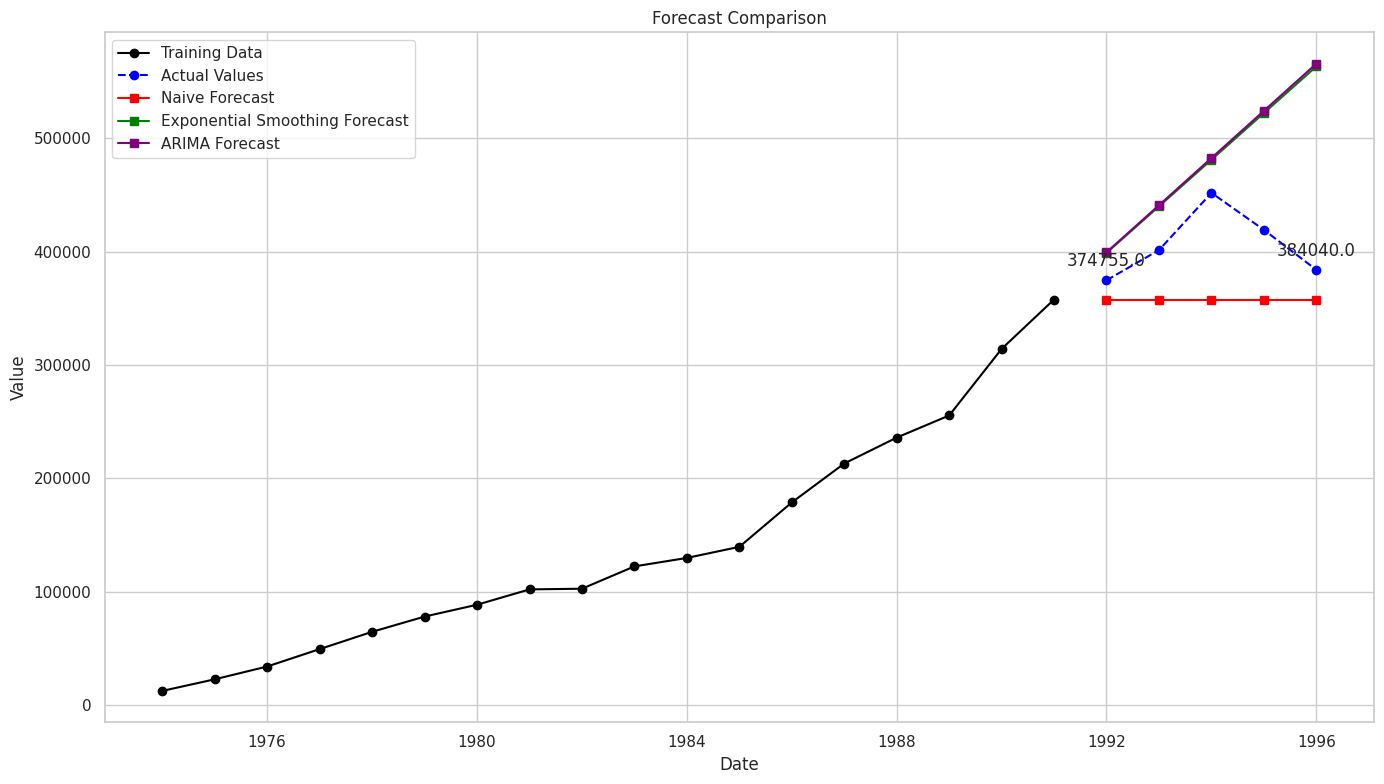

<Figure size 1400x800 with 0 Axes>

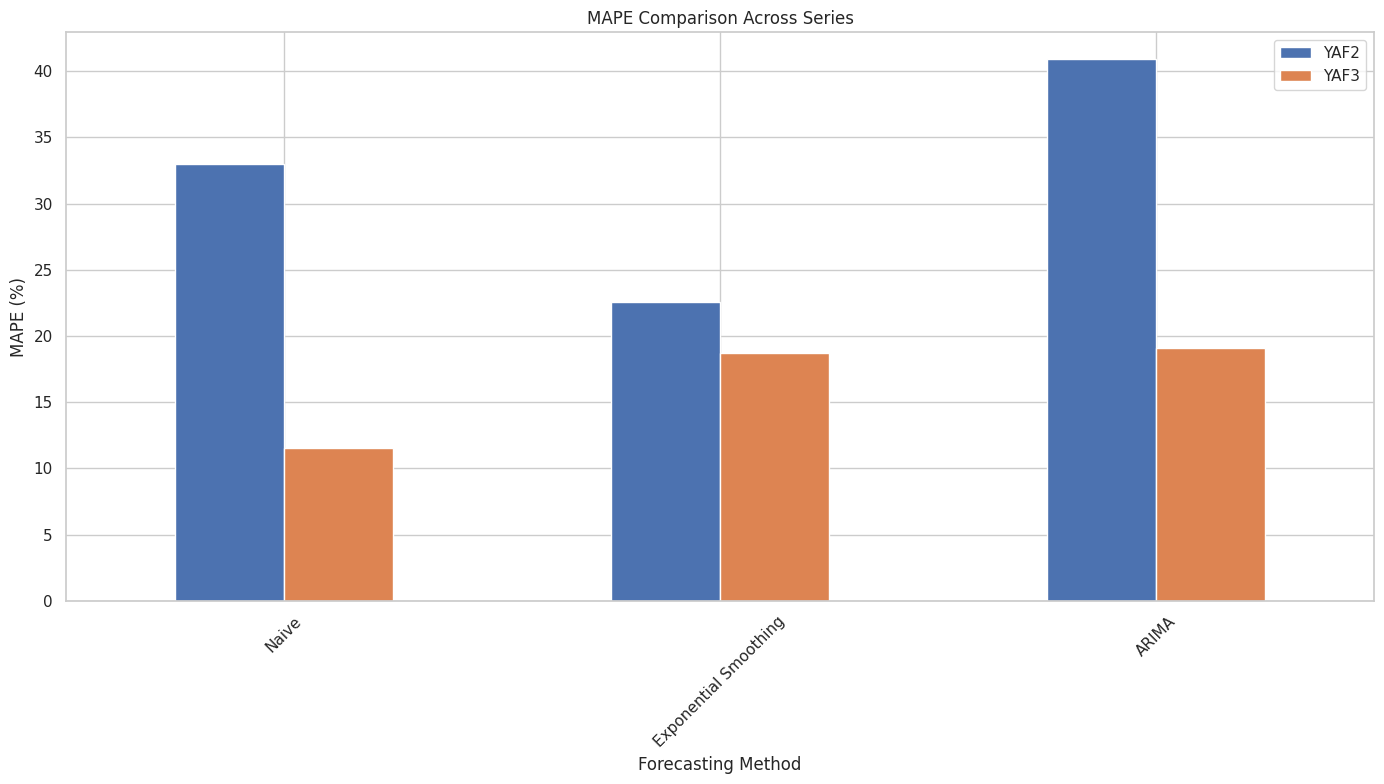

In [41]:
# Run for multiple series
series_to_analyze = ['YAF2', 'YAF3']  # Update with your chosen series
all_results, mape_comparison = analyze_multiple_series(file_path, series_to_analyze)